In [35]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import torch
from torch import nn
from torch.utils.data import DataLoader
from torch.utils.data import Dataset
from torchvision.transforms import ToTensor


In [36]:
class Data(Dataset):
    def __init__(self, filename):
        df = pd.read_pickle(filename)
        dfx = df.drop(columns=['X'])
        dfy = df.drop(columns=['FAI', 'PA', 'A', 'Phase', 'DeltaTime'])
        
        x = dfx.iloc[:,:].values
        y = dfy.iloc[:, :].values

        x = np.array(x, dtype=np.float32)
        self.X = torch.from_numpy(x)
        self.X = torch.squeeze(self.X)

        print(f'{filename} X size: {self.X.shape}')

        outputs = []
        for i in range(len(y)):
            outputs.append(y[i, :])
            
        self.y = torch.tensor(outputs, dtype=torch.float32)
        self.y = torch.squeeze(self.y)
        self.y = torch.squeeze(self.y)
        print(f'{filename} Y size: {self.y.shape}')
        

    
    def __len__(self):
        return len(self.y)

    def __getparams__(self):
        return self.X, self.y

    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]



In [37]:


batch_size = 1

train_data = Data(filename='train-data-oha.pkl')
test_data = Data(filename='test-data-oha.pkl')

train_dataloader = DataLoader(train_data, shuffle=True)
test_dataloader = DataLoader(test_data, shuffle=True)


for X, y in train_dataloader:
    print(f"Shape of X [N, Params]: {X.shape}")
    test_x = X
    print(f"Shape of y [N, Params]: {y.shape} {y.dtype}")
    test_y = y
    break

train-data-oha.pkl X size: torch.Size([5000, 5])
train-data-oha.pkl Y size: torch.Size([5000, 300])
test-data-oha.pkl X size: torch.Size([5000, 5])
test-data-oha.pkl Y size: torch.Size([5000, 300])
Shape of X [N, Params]: torch.Size([1, 5])
Shape of y [N, Params]: torch.Size([1, 300]) torch.float32


In [38]:
# Get cpu or gpu device for training.
device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Using {device} device")


# Define model
class NeuralNetwork(nn.Module):
    def __init__(self):
        super().__init__()
        self.flatten = nn.Flatten()
        self.linear_relu_stack = nn.Sequential(
            nn.Linear(5, 128),
            nn.ReLU(),
            nn.Linear(128, 256),
            nn.ReLU(),
            nn.Linear(256, 256),
            nn.ReLU(),
            nn.Linear(256, 300)
        )

    def forward(self, x):
        x = self.flatten(x)
        logits = self.linear_relu_stack(x)
        return logits


model = NeuralNetwork().to(device)
print(model)

loss_fn = nn.MSELoss()
optimizer = torch.optim.SGD(model.parameters(), lr=0.001)


Using cuda device
NeuralNetwork(
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (linear_relu_stack): Sequential(
    (0): Linear(in_features=5, out_features=128, bias=True)
    (1): ReLU()
    (2): Linear(in_features=128, out_features=256, bias=True)
    (3): ReLU()
    (4): Linear(in_features=256, out_features=256, bias=True)
    (5): ReLU()
    (6): Linear(in_features=256, out_features=300, bias=True)
  )
)


In [39]:
def train(dataloader, model, loss_fn, optimizer):
    size = len(dataloader.dataset)
    model.train()
    for batch, (X, y) in enumerate(dataloader):
        X, y = X.to(device), y.to(device)

        # Compute prediction error
        pred = model(X)
        loss = loss_fn(pred, y)

        # Backpropagation
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        if batch % 100 == 0:
            loss, current = loss.item(), batch * len(X)
            print(f"loss: {loss:>7f}  [{current:>5d}/{size:>5d}]")


def test(dataloader, model, loss_fn):
    size = len(dataloader.dataset)
    num_batches = len(dataloader)
    model.eval()
    test_loss, correct = 0, 0
    with torch.no_grad():
        for X, y in dataloader:
            X, y = X.to(device), y.to(device)
            pred = model(X)
            test_loss += loss_fn(pred, y).item()
            correct += (pred.argmax(1) == y).type(torch.float).sum().item()
    test_loss /= num_batches
    correct /= size
    print(f"Test Error: \n Accuracy: {(100*correct):>0.1f}%, Avg loss: {test_loss:>8f} \n")

In [40]:
epochs = 15
for t in range(epochs):
    print(f"Epoch {t+1}\n-------------------------------")
    train(train_dataloader, model, loss_fn, optimizer)
    test(test_dataloader, model, loss_fn)
print("Done!")

Epoch 1
-------------------------------
loss: 4.842700  [    0/ 5000]
loss: 0.676385  [  100/ 5000]
loss: 0.014150  [  200/ 5000]
loss: 4.270140  [  300/ 5000]
loss: 0.996626  [  400/ 5000]
loss: 0.266973  [  500/ 5000]
loss: 3.164845  [  600/ 5000]
loss: 0.005874  [  700/ 5000]
loss: 6.415883  [  800/ 5000]
loss: 1.971574  [  900/ 5000]
loss: 0.514689  [ 1000/ 5000]
loss: 0.929281  [ 1100/ 5000]
loss: 0.442867  [ 1200/ 5000]
loss: 0.570437  [ 1300/ 5000]
loss: 0.026146  [ 1400/ 5000]
loss: 0.034483  [ 1500/ 5000]
loss: 0.176362  [ 1600/ 5000]
loss: 0.588350  [ 1700/ 5000]
loss: 1.277087  [ 1800/ 5000]
loss: 0.069926  [ 1900/ 5000]
loss: 2.199167  [ 2000/ 5000]
loss: 6.751662  [ 2100/ 5000]
loss: 57.948269  [ 2200/ 5000]
loss: 0.906282  [ 2300/ 5000]
loss: 0.017943  [ 2400/ 5000]
loss: 0.106388  [ 2500/ 5000]
loss: 2.277515  [ 2600/ 5000]
loss: 29.626686  [ 2700/ 5000]
loss: 147.796005  [ 2800/ 5000]
loss: 10.953046  [ 2900/ 5000]
loss: 18.770172  [ 3000/ 5000]
loss: 0.486589  [ 3100/ 

In [41]:
torch.save(model.state_dict(), "model.pth")
print("Saved PyTorch Model State to model.pth")

model = NeuralNetwork().to(device)
model.load_state_dict(torch.load("model.pth"))

Saved PyTorch Model State to model.pth


<All keys matched successfully>

300


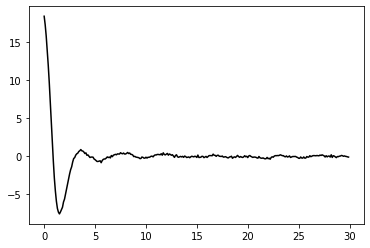

In [42]:
test_x = test_x.to(device)
test_y = test_y.to(device)

model.eval()
with torch.no_grad():
    pred = model(test_x)

pred = torch.squeeze(pred)
pred = torch.squeeze(pred)

pred = pred.cpu() # Para transformar em numpy, vê-se necessário passar a variável para o cpu

y = pred.numpy()

print(y.size)

dt = 0.1
max_time = 30
tempo = np.arange(0, max_time, dt)



plt.plot(tempo, y, 'k-')
plt.show()